In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import csv
import random
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch.utils.data import  Dataset, DataLoader, ConcatDataset
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score
import glob

In [2]:
seed = 10
torch.manual_seed(seed)

image_size = 200
train_transform = transforms.Compose([
    # transforms.Resize((image_size,image_size)),
    # transforms.RandomAffine(degrees=10),
    # transforms.Pad(10),
    transforms.CenterCrop((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    # transforms.Resize((image_size,image_size)),
    transforms.CenterCrop((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


CC_train = datasets.ImageFolder("CC/Train", transform=train_transform)
CC_valid = datasets.ImageFolder("CC/Valid", transform=test_transform)
CC_test = datasets.ImageFolder("CC/Test", transform=test_transform)

MLO_train = datasets.ImageFolder("MLO/Train", transform=train_transform)
MLO_valid = datasets.ImageFolder("MLO/Valid", transform=test_transform)
MLO_test = datasets.ImageFolder("MLO/Test", transform=test_transform)

train_annotations = []
valid_annotations = []
test_annotations = []
with open("annotation.csv", newline='') as f:
    rows = list(csv.reader(f, delimiter = ','))
    annotation_data = pd.DataFrame(rows[1:], columns=rows[0])

for i in range(len(CC_train)):
    image_CC = CC_train.imgs[i][0]

    information_CC = image_CC.split("\\")[-1].split("_")
    PID_CC = information_CC[0]
    L_R_CC = information_CC[1]
    
    annotation_CC = annotation_data.loc[ (annotation_data["PID"] == PID_CC) & (annotation_data["L_R"] == L_R_CC)]
    annotation_CC = annotation_CC.drop(['PID', 'L_R', 'position'], axis=1)
        
    annota = annotation_CC.values[0]
    train_annotations.append([int (annota[0]), int (annota[1]), int (annota[2]), int (annota[3])])

for i in range(len(CC_valid)):
    image_CC = CC_valid.imgs[i][0]

    information_CC = image_CC.split("\\")[-1].split("_")
    PID_CC = information_CC[0]
    L_R_CC = information_CC[1]
    
    annotation_CC = annotation_data.loc[ (annotation_data["PID"] == PID_CC) & (annotation_data["L_R"] == L_R_CC)]
    annotation_CC = annotation_CC.drop(['PID', 'L_R', 'position'], axis=1)

    annota = annotation_CC.values[0]
    valid_annotations.append([int (annota[0]), int (annota[1]), int (annota[2]), int (annota[3])])

for i in range(len(CC_test)):
    image_CC = CC_test.imgs[i][0]

    information_CC = image_CC.split("\\")[-1].split("_")
    PID_CC = information_CC[0]
    L_R_CC = information_CC[1]
    
    annotation_CC = annotation_data.loc[ (annotation_data["PID"] == PID_CC) & (annotation_data["L_R"] == L_R_CC)]
    annotation_CC = annotation_CC.drop(['PID', 'L_R', 'position'], axis=1)
        
    annota = annotation_CC.values[0]
    test_annotations.append([int (annota[0]), int (annota[1]), int (annota[2]), int (annota[3])])

In [3]:
batch_size = 12

In [4]:
class Resnet_annotation(nn.Module):
    def __init__(self, resnetCC, resnetMLO):
        super(Resnet_annotation, self).__init__()
        self.resnetCC = resnetCC
        self.resnetMLO = resnetMLO
        self.CC = nn.Linear(1000, 2)
        self.MLO = nn.Linear(1000, 2)
        self.classifier = nn.Linear(2000 + 4, 2)
    def forward(self, CC, MLO, annotation):
        CC = self.resnetCC(CC)
        MLO = self.resnetMLO(MLO)
        x = torch.cat((CC, MLO, annotation), dim=1)
        x = self.classifier(F.relu(x))
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = Resnet_annotation(models.resnet18(pretrained = True), models.resnet18(pretrained = True))
resnet = resnet.cuda() if device else resnet

In [6]:
learning_rate = 0.001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = optim.Adam(resnet.parameters(), lr = learning_rate)

In [7]:
n_epochs = 10
early_stop = 0.01
print_every = 100
valid_loss_min = np.inf
last_auc = -1
val_loss = []
val_acc = []
train_loss = []
train_acc = []
if (len(CC_train) % batch_size == 0):
    batch_num = int(len(CC_train) / batch_size)
else:
    batch_num = int(len(CC_train) / batch_size) + 1


In [8]:
zero_count = int (0.5 * batch_size)
one_count =  batch_size - zero_count

In [9]:
zeros = [x for x in range(len(CC_train.targets)) if CC_train.targets[x] == 0]
ones = [x for x in range(len(CC_train.targets)) if CC_train.targets[x] == 1]
zeros = random.sample(zeros, len(zeros))
ones = random.sample(ones, len(ones))

loop_zero = 0
loop_one = 0
indices = []
rs = random.sample(range(len(CC_train)), len(CC_train))
for batch_ID in range(batch_num):
    if ((batch_ID+1)*batch_size <= len(CC_train)):
        indices.append(rs[batch_ID*batch_size : (batch_ID+1)*batch_size])
    else:
        indices.append(rs[batch_ID*batch_size :] + rs[:((batch_ID+1)*batch_size) % batch_size])

In [10]:
for epoch in range(1, n_epochs):
    # train
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_ID in range(batch_num):
        batch_index = indices[batch_ID]
        
        CC_image = torch.Tensor([])
        MLO_image = torch.Tensor([])
        label = torch.Tensor([])
        annotation = torch.Tensor([])
        for i in batch_index:
            CC_image = torch.cat([CC_image, CC_train[i][0]], dim=0)
            MLO_image = torch.cat([MLO_image, MLO_train[i][0]], dim=0)
            label = torch.cat([label, torch.Tensor([CC_train[i][1]])], dim=0)
            annotation = torch.cat([annotation, torch.Tensor(train_annotations[i])])
        CC_image = CC_image.reshape((len(batch_index), 3, image_size, image_size)).to(device)
        MLO_image = MLO_image.reshape((len(batch_index), 3, image_size, image_size)).to(device)
        label = label.to(device).long()
        annotation = annotation.reshape((len(batch_index), 4)).to(device)

        optimizer.zero_grad()
        train_predict = resnet(CC_image, MLO_image, annotation)
        loss = criterion(train_predict,label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, train_prediction = torch.max(train_predict, dim=1)
        correct += torch.sum(train_prediction == label).item()
        total += label.size(0)
        if (batch_ID) % print_every == 0 and batch_ID != 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch, n_epochs, batch_ID, batch_num, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / batch_num)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    # validation
    batch_loss = 0.0
    total_t=0
    correct_t=0

    predict = torch.Tensor([])
    label = torch.Tensor([])
    with torch.no_grad():
        resnet.eval()
        for i in range(len(CC_valid)):
            CC_valid_image = CC_valid[i][0].to(device).unsqueeze(0)
            MLO_valid_image = MLO_valid[i][0].to(device).unsqueeze(0)
            valid_label = torch.Tensor([[CC_valid[i][1]]]).to(device).long()
            valid_annotation = torch.Tensor([valid_annotations[i]]).to(device)
            
            valid_predict = resnet(CC_valid_image, MLO_valid_image, valid_annotation) 
            valid_loss = criterion(valid_predict, valid_label[0])
            
            batch_loss += valid_loss.item()
            
            _, valid_prediction = torch.max(valid_predict, dim=1)
            correct_t += torch.sum(valid_prediction == valid_label).item()
            total_t += valid_label.size(0)

            predict = torch.cat([predict, valid_prediction.cpu()])
            label = torch.cat([label, valid_label.cpu()])
            
    auc = roc_auc_score(label.numpy(), predict.numpy())
    val_acc.append(100 * correct_t/total_t)
    val_loss.append(batch_loss/len(CC_valid))
    print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}', "AUC:", auc)
    
    # network_learned = batch_loss < valid_loss_min
    network_learned = auc > last_auc
    if network_learned:
        # valid_loss_min = batch_loss
        last_auc = auc
        torch.save(resnet.state_dict(), 'resnet_annotation.pt')
        print('Improvement-Detected, save-model')
    resnet.train()
        


train-loss: 0.8949, train-acc: 62.6667
validation loss: 0.8303, validation acc: 62.2222 AUC: 0.5502645502645502
Improvement-Detected, save-model

train-loss: 0.8205, train-acc: 70.6667
validation loss: 0.9285, validation acc: 52.2222 AUC: 0.5105820105820106

train-loss: 0.6978, train-acc: 82.8333
validation loss: 1.0343, validation acc: 68.8889 AUC: 0.6296296296296295
Improvement-Detected, save-model

train-loss: 0.6219, train-acc: 85.5833
validation loss: 1.1465, validation acc: 60.0000 AUC: 0.5873015873015873

train-loss: 0.5543, train-acc: 89.2500
validation loss: 1.2234, validation acc: 68.8889 AUC: 0.5555555555555556

train-loss: 0.4869, train-acc: 94.8333
validation loss: 1.2752, validation acc: 63.3333 AUC: 0.5158730158730159

train-loss: 0.4277, train-acc: 97.4167
validation loss: 1.3081, validation acc: 64.4444 AUC: 0.5343915343915344

train-loss: 0.3764, train-acc: 99.5000
validation loss: 1.3192, validation acc: 67.7778 AUC: 0.5476190476190477

train-loss: 0.3355, train-acc

In [11]:
final_model = Resnet_annotation(models.resnet18(pretrained = False), models.resnet18(pretrained = False))
final_model.load_state_dict(torch.load("resnet_annotation.pt"))

<All keys matched successfully>

In [12]:
with torch.no_grad():
    # validation
    batch_loss = 0.0
    total_t=0
    correct_t=0

    predict = torch.Tensor([])
    label = torch.Tensor([])
    with torch.no_grad():
        resnet.eval()
        for i in range(len(CC_test)):
            CC_test_image = CC_test[i][0].to(device).unsqueeze(0)
            MLO_test_image = MLO_test[i][0].to(device).unsqueeze(0)
            test_label = torch.Tensor([CC_test[i][1]]).to(device).long()
            test_annotation = torch.Tensor([test_annotations[i]]).to(device)
            
            test_predict = resnet(CC_test_image, MLO_test_image, test_annotation) 
            test_loss = criterion(test_predict, test_label)
            
            batch_loss += test_loss.item()
            
            ind, test_prediction = torch.max(test_predict, dim=1)
            # print(ind)
            correct_t += torch.sum(test_prediction == test_label).item()
            total_t += test_label.size(0)

            predict = torch.cat([predict, test_prediction.cpu()])
            label = torch.cat([label, test_label.cpu()])
        # print(label)
        # print(predict)
        
    auc_t = roc_auc_score(label.cpu().numpy(), predict.cpu().numpy())
    TP = np.sum(np.logical_and(label.cpu().numpy() == 1, predict.cpu().numpy() == 1))
    TN = np.sum(np.logical_and(label.cpu().numpy() == 0, predict.cpu().numpy() == 0))
    FP = np.sum(np.logical_and(label.cpu().numpy() == 0, predict.cpu().numpy() == 1))
    FN = np.sum(np.logical_and(label.cpu().numpy() == 1, predict.cpu().numpy() == 0))
    
   

In [13]:
print("test accuracy:", correct_t / total_t, "test auc:", auc_t)
print("TP", TP / len(predict))
print("TN", TN / len(predict))
print("FP", FP / len(predict))
print("FN", FN / len(predict))
    

test accuracy: 0.7524752475247525 test auc: 0.6285960874568469
TP 0.0891089108910891
TN 0.6633663366336634
FP 0.1188118811881188
FN 0.12871287128712872


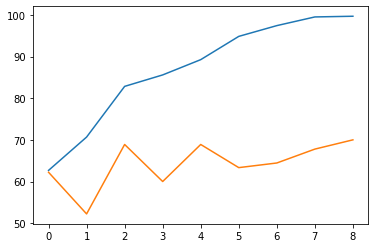

In [14]:
plt.plot(train_acc)
plt.plot(val_acc)

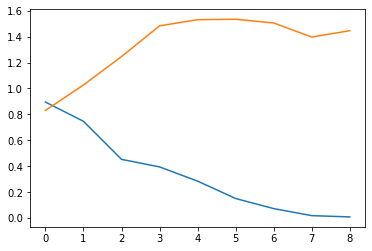

In [15]:
plt.plot(train_loss)
plt.plot(val_loss)